Units removed for faster computing, creates heatmap only

In [86]:
%matplotlib notebook

from matplotlib import *

from modsim import *

In [87]:
condition = Condition(x = 0, 
                      y = 0,
                      g = 9.8,
                      mass = 1e-3,
                      diameter = 1e-2,
                      rho = 1.2,
                      C_d = .67,
                      angle = 0,
                      velocity = 10,
                      duration = 20)

In [88]:
def make_system(condition):
    """Make a system object.
    
    condition: Condition object with angle, velocity, x, y,
               diameter, duration, g, mass, rho, and C_d
               
    returns: System object
    """
    unpack(condition)
    
    # convert angle to degrees
    theta = np.deg2rad(angle)
    
    # compute x and y components of velocity
    vx, rel_vy = pol2cart(theta, velocity)
    abs_vy = rel_vy + 53
    
    # make the initial state
    init = State(x=x, abs_y=y, rel_y=y, vx=vx, abs_vy=abs_vy, rel_vy = rel_vy)
    
    # compute area from diameter
    area = np.pi * (diameter/2)**2
    
    # compute timestamps
    ts = linspace(0, duration, 200)
    
    return System(init=init, g=g, mass=mass, 
                  area=area, rho=rho, C_d=C_d, ts=ts)

def slope_func(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (vx, vy, ax, ay)
    """
    x, abs_y, rel_y, vx, abs_vy, rel_vy = state
    unpack(system)
    
    f_drag_x = -rho * vx**2 * C_d * area / 2
    a_x = f_drag_x / mass
    
    f_drag_y = -rho * abs_vy**2 * C_d * area / 2
    a_y = f_drag_y / mass + g
    
    vx = vx + (a_x * t)
    abs_vy = abs_vy + (a_y * t)
    rel_vy = abs_vy - 53
    
    return vx, abs_vy, rel_vy, a_x, a_y, a_y

In [89]:
system = make_system(condition)
slope_func(system.init, 0, system)
run_odeint(system, slope_func)

In [90]:
#Absolute
xs = system.results.x
abs_ys = -system.results.abs_y
vxs = system.results.vx
abs_vys = system.results.abs_vy

#Relative
xs = system.results.x
rel_ys = -system.results.rel_y
vxs = system.results.vx
rel_vys = system.results.rel_vy

<IPython.core.display.Javascript object>


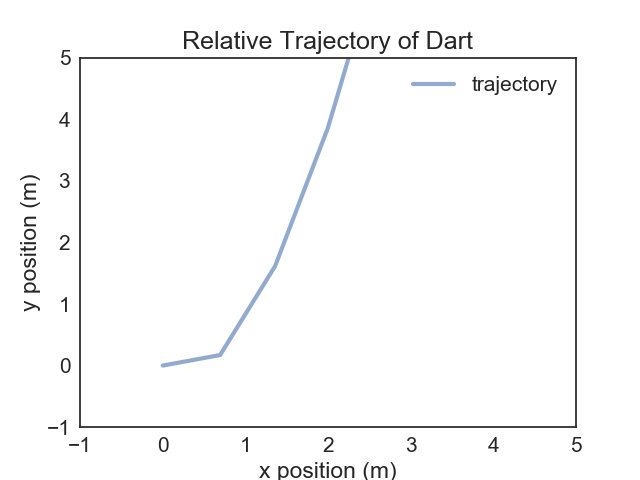

<IPython.core.display.Javascript object>


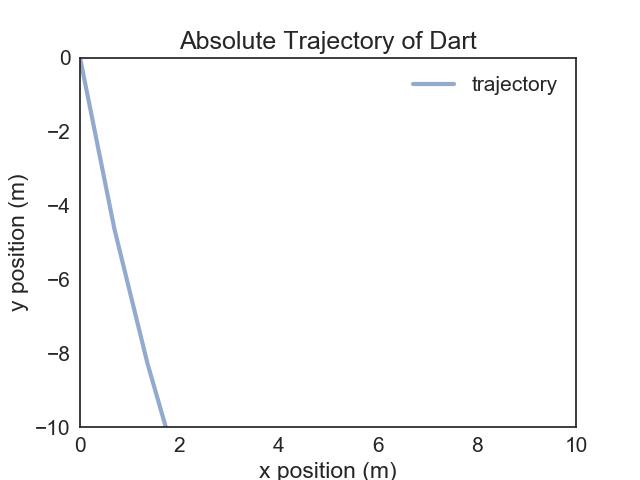

<IPython.core.display.Javascript object>


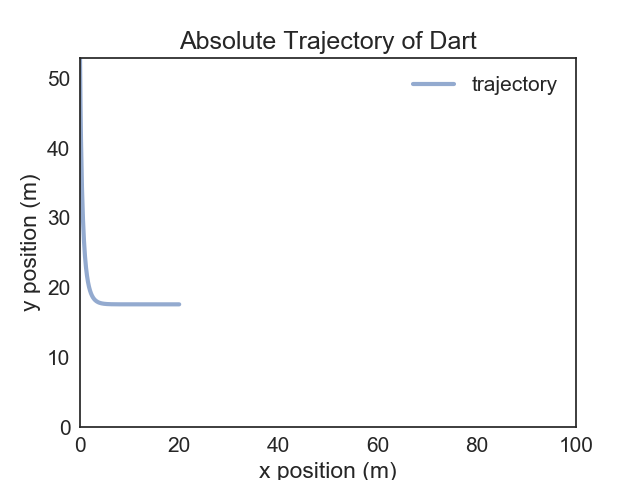

0.3019069309672845
3.864876083623362


In [91]:
def calc_miss(angle, distance):
    condition.set(angle = angle)
    #print(condition.angle)
    system = make_system(condition)
    #print(system)
    slope_func(system.init, 0, system)
    run_odeint(system, slope_func)
    
    xs = system.results.x
    rel_ys = -system.results.rel_y
    
    x_series = interpolate(xs, kind = 'cubic')
    y_series = interpolate(rel_ys, kind = 'cubic')
    
    T = interp_inverse(xs, kind='cubic')  #adjust later
    hit_time = T(distance)
    print(hit_time)
    hit_height = y_series(hit_time)

    print(hit_height)
    
def plot_trajectory(angle, distance):
    condition.set(angle = angle)
    #print(condition.angle)
    system = make_system(condition)
    #print(system)
    slope_func(system.init, 0, system)
    run_odeint(system, slope_func)
    
    xs = system.results.x
    rel_ys = -system.results.rel_y
    
    x_series = interpolate(xs, kind = 'cubic')
    y_series = interpolate(rel_ys, kind = 'cubic')
     
    #Relative Graph
    newfig()
    plot(xs, rel_ys, label='trajectory')
    
    decorate(xlabel='x position (m)',
             ylabel='y position (m)',
             title='Relative Trajectory of Dart',
             xlim=[-1, 5],
             ylim=[-1, 5]
            )
    
    #Absolute Graph
    newfig()
    plot(xs, abs_ys, label='trajectory')

    decorate(xlabel='x position (m)',
             ylabel='y position (m)',
             title='Absolute Trajectory of Dart',
             xlim=[0, 10],
             ylim=[-10, 0])
    
    newfig()
    plot(ts, abs_vys, label='trajectory')

    decorate(xlabel='x position (m)',
             ylabel='y position (m)',
             title='Absolute Trajectory of Dart',
             xlim=[0, 100],
             ylim=[0, 53]
             )

#run_simulation(20,2)
plot_trajectory(45,2)
calc_miss(45,2)

In [92]:
def hit_or_miss(angle, distance, height):
    hit = State(None)
    
    condition.set(angle = angle)
    #print(condition.angle)
    system = make_system(condition)
    #print(system)
    slope_func(system.init, 0, system)
    run_odeint(system, slope_func)
    
    xs = system.results.x
    rel_ys = -system.results.rel_y
    
    x_series = interpolate(xs, kind = 'cubic')
    y_series = interpolate(rel_ys, kind = 'cubic')
    
    T = interp_inverse(xs, kind='cubic')  #adjust later
    hit_time = T(distance)
    #print(hit_time)
    hit_height = y_series(hit_time)
    #print(hit_height)
    
    error = abs(hit_height-height)
        
    return error

def calc_trajectory(distance, height):
    ideal = min_bounded(hit_or_miss, [-90, 90], distance, height)
    print (ideal)

In [130]:
def plot_point(angle, distance, height, hit_or_miss, color):
    result = hit_or_miss(angle, distance, height)
    #print(result)
    #print(distance)
    #print(height)
    if result < 0.2:
        plot(distance, height, color)
    
#plot_point(45, 1, 0.55, hit_or_miss)
        
#hit_or_miss(45, 1, 0.55)

def plot_line(angle, distance, height):
    result = hit_or_miss(angle, distance, height)
    if result < .2:
        plot(distance, angle, 'b-', label = height)

distances = linspace(.5,3,20)
heights = linspace(1,1,1)
angles = linspace(-60,60,20)
colors = ['rs', 'ms', 'bs', 'ks', 'cs', 'gs', 'ys']

def sweep_trajectory(angles, distances, heights, colors):
    for height in heights:
        for distance in distances:
            for angle, color in zip(angles, colors):
                plot_point(angle, distance, height, hit_or_miss, color)
                
def create_line(angles, distances, heights):
    for angle in angles:
        for distance in distances:
             for height in heights:
                plot_line(angle, distance, height)

<IPython.core.display.Javascript object>


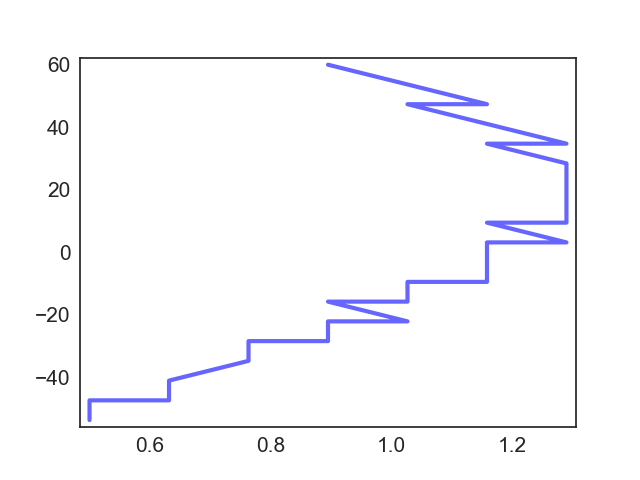

In [131]:
newfig()
create_line(angles, distances, heights)

<IPython.core.display.Javascript object>


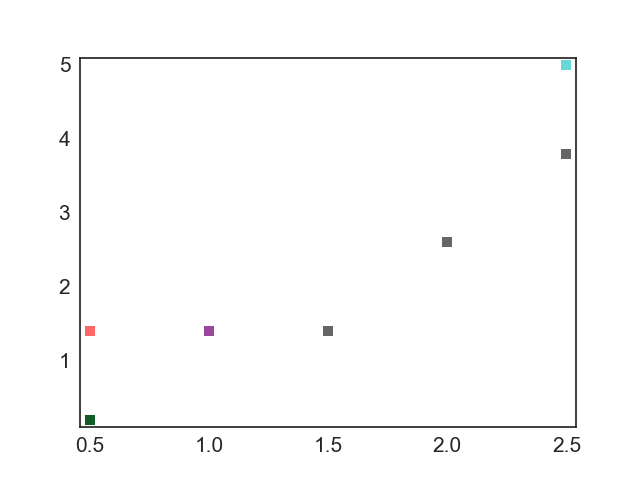

2.35184809636
1.58969315332
1.29262589686
1.1116523306
0.989674318296
1.06915519682
4.51219063873
2.57338823478
1.90496366871
1.58873082895
1.55713215911
2.55480718412
7.29969159055
3.90996425299
2.81332976973
2.40018512762
2.61959501865
5.00748306307
10.5926739751
5.5511232183
3.98598513425
3.50496224976
4.08221748527
8.1656425265
14.3059702116
7.465161574
5.39333159454
4.86517265388
5.88692020312
11.8644233279
18.3794714929
9.62830856407
7.01856236792
6.45980828625
7.99255371608
15.997436684
1.15184809636
0.389693153315
0.0926258968581
0.0883476694014
0.210325681704
0.130844803178
3.31219063873
1.37338823478
0.704963668714
0.388730828953
0.357132159112
1.35480718412
6.09969159055
2.70996425299
1.61332976973
1.20018512762
1.41959501865
3.80748306307
9.39267397513
4.3511232183
2.78598513425
2.30496224976
2.88221748527
6.9656425265
13.1059702116
6.265161574
4.19333159454
3.66517265388
4.68692020312
10.6644233279
17.1794714929
8.42830856407
5.81856236792
5.25980828625
6.79255371608
14.79

In [116]:
newfig()
sweep_trajectory(heights, distances, angles, colors)

In [44]:
calc_trajectory(1,1)

     fun: 2.7618200045820274e-06
 message: 'Solution found.'
    nfev: 22
  status: 0
 success: True
       x: -16.726318025540714


<IPython.core.display.Javascript object>


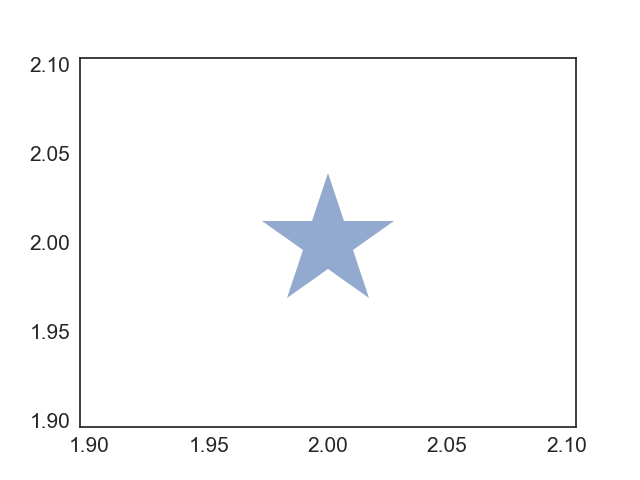

In [50]:
newfig()
plot(2,2,marker='*',markersize=100)